<a href="https://colab.research.google.com/github/nanopiero/PREAC/blob/main/TestPerceiver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test Perceiver :
I) Régression
II) Fusion

In [2]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

In [ ]:
!nvidia-smi

In [3]:
import torch
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import os

#############################################################
#pour la visualisation des images ###########################
#############################################################

def voir_mat(data2, fig, min_scale=-10,max_scale=70):

    ax = fig.add_subplot(1,1,1)
    ax.set_aspect('equal')
    plt.imshow(data2, interpolation='nearest', cmap=plt.cm.rainbow) #cmap=plt.cm.ocean)
    plt.clim(min_scale,max_scale)
    plt.colorbar()
    plt.show()

def voir_tens(image, fig, min_scale=-1,max_scale=1):
    im=image[0,0,:,:].numpy()
    ax = fig.add_subplot(1,1,1)
    ax.set_aspect('equal')
    plt.imshow(im, interpolation='nearest',  cmap=plt.cm.rainbow) #cmap=plt.cm.ocean)
    plt.clim(min_scale,max_scale)
    plt.colorbar()
    plt.show()

def conc(image1,image2,dim=3):
    return torch.cat((image1,image2), dim) #, out=None)

def multi_conc(L,dim=1,ecart=5, min_scale=0.5):
    image1=L[0]
    for i in range(1, len(L)):
        if dim==1:
            sep=  min_scale + 0*image1[:,0:ecart]
        elif dim==0:
            sep=  min_scale + 0*image1[0:ecart,:]
        image1=conc(image1,sep,dim)
        image2=L[i]
        image1=conc(image1,image2,dim=dim)
    return image1

def images_from_tenseur(tens, k=0):
    len_batch=tens.shape[0]
    L=[]
    for i in range(len_batch):
        L.append(tens[i,k,:,:])
    return L

def voir_batch2D(tens, nx, fig,k=0, min_scale=-10,max_scale=1):
    s = 0.5*(min_scale + max_scale)
    L=images_from_tenseur(tens,k)
    image1=multi_conc(L[0:nx],dim=1, min_scale=s)
    for i in range(1,int(len(L)/nx)):
        image2=multi_conc(L[i*nx:(i+1)*nx],dim=1, min_scale=s)
        image1=multi_conc([image1,image2],dim=0, min_scale=s)
    voir_mat(image1, fig, min_scale,max_scale)


#############################################################
#pour la génération des images    ###########################
#############################################################

def simu_rec(image, L,l,  fields=0):
    channels,size,size2=image.size()
    rec= torch.zeros(channels,size,size2)
    #out = 0*(image.clone())
    vertical=np.random.binomial(1,0.5)==1
    if vertical:
        width=l
        height=L
    else:
        width=L
        height=l

    top=randint(0, size-height)
    left=randint(0, size-width)
    rec[fields,top:top+height,left:left+width]=  np.random.uniform(0,0.4)   #0.1
    image=image + rec
    return image

def simu_noisy_rec(image, L,l,  fields=0):
    channels,size,size2=image.size()
    rec= torch.zeros(channels,size,size2)
    #out = 0*(image.clone())
    vertical=np.random.binomial(1,0.5)==1
    if vertical:
        width=l
        height=L
    else:
        width=L
        height=l

    top=randint(0, size-height)
    left=randint(0, size-width)
    rec[fields,top:top+height,left:left+width]= np.random.uniform(0,0.4)  #0.1
    noise=torch.randn(channels,size,size2)
    noise=noise*(noise>0).float()
    rec=noise*rec
    image=image + rec
    return image

def simu_disc(image, f, radius=15, fields=0 ):  #radial decrease function  #or 12
    channels,size,size2=image.size()
    center=np.array([randint(radius, size-radius) , randint(radius, size-radius) ])
    npdisc= f( ((np.arange(0,64)*np.ones([size,size])) - center[0])**2 + (np.transpose(np.arange(0,64)*np.ones([size,size]))-center[1])**2  , radius)
    npdisc=np.random.uniform(0.6,1.) * npdisc  #variation on intensity
    image[fields,:,:] = image[fields,:,:] + torch.from_numpy(npdisc).float()   #matrice des distances < rayon
    return image

def simu_disc_with_cond(image, f, radius=15, fields=0, f2 = lambda a,x  : ((np.sin(3.1 * a/x**2)))*(a < x**2) ):  #radial decrease function  #or 12
    channels,size,size2=image.size()
    center=np.array([randint(radius-5, size-radius+2) , randint(radius-2, size-radius+5) ])
    npdisc= f( ((np.arange(0,64)*np.ones([size,size])) - center[0])**2 + (np.transpose(np.arange(0,64)*np.ones([size,size]))-center[1])**2  , radius)
    npdisc=np.random.uniform(0.6,1.) * npdisc  #variation on intensity
    image[0,:,:] = image[0,:,:] + torch.from_numpy(npdisc).float()   #matrice des distances < rayon
    if (radius >= 10) and (radius <= 14):
        npdon = f2( ((np.arange(0,64)*np.ones([size,size])) - center[0])**2 + (np.transpose(np.arange(0,64)*np.ones([size,size]))-center[1])**2  , radius)
        image[1,:,:] = image[1,:,:] + torch.from_numpy(npdon).float()**2
    return image


def simu_square(image, f, diag=15, fields=0 ):  #radial decrease function  #or 12
    channels,size,size2 = image.size()
    center=np.array([randint(diag, size-diag) , randint(diag, size-diag) ])

    npsquare = f(  np.abs(np.arange(0,64)*np.ones([size,size]) - center[0]) + \
                   np.abs(np.transpose(np.arange(0,64)*np.ones([size,size]))-center[1]), diag)
#    npsquare = np.abs(np.arange(0,64)*np.ones([size,size]) - center[0])
    npsquare = np.random.uniform(0.6,1.) * npsquare  #variation on intensity
    image[fields,:,:] = image[fields,:,:] + torch.from_numpy(npsquare).float()   #matrice des distances < rayon
    return image


def plot_pairs(image, f = lambda x : x**2):
    horizontal = (torch.randint(0,2,(1,)) > 0.5).item()
#    print(horizontal)
    dist = torch.randint(1,32, (1,)).item()
    if horizontal :
        ordo = torch.randint(0, 64, (1,)).item()
        absi = torch.randint(0, 64 - dist, (1,)).item()
        image[1, ordo, absi:(absi + dist + 1)] \
            += 0.1 + torch.mean(f(image[0, ordo, absi:(absi + dist + 1)]))
    else :
        ordo = torch.randint(0, 64 - dist, (1,)).item()
        absi = torch.randint(0, 64, (1,)).item()
        image[1, ordo:ordo+dist+1, absi] \
            += 0.1 + torch.mean(f(image[0, ordo:ordo+dist+1, absi]))
    return image



def make_image(rec, noisy_rec ,disc,square=0., pola=[0]):
    image=torch.zeros([1,64, 64])
    image = generate_noise(image, lambda_rec=rec, lambda_noisy_rec = noisy_rec,lambda_disc = disc, lambda_square = square, pola= pola)
    return image

def make_image_with_cond(rec, noisy_rec ,disc,square=0., pola=[0]):
    image = torch.zeros([2, 64, 64])
    image = generate_noise_with_cond(image, lambda_rec=rec, lambda_noisy_rec = noisy_rec,lambda_disc = disc, lambda_square = square, pola= pola)
    return image

def make_batch(batch_size, rec, noisy_rec ,disc, square=0., pola=[0] ):
    out = make_image(rec, noisy_rec ,disc , square, pola ).unsqueeze(0)
    for i in range(batch_size-1):
        new=make_image(rec, noisy_rec ,disc, square, pola).unsqueeze(0)
        out=torch.cat((out,new), dim=0)
    return out

def make_batch_with_cond(batch_size, rec, noisy_rec ,disc, square=0.):
    out = make_image_with_cond(rec, noisy_rec ,disc , square).unsqueeze(0)
    for i in range(batch_size-1):
        new=make_image_with_cond(rec, noisy_rec ,disc, square).unsqueeze(0)
        out=torch.cat((out,new), dim=0)
    return out

def make_image_with_pairs(rec, freq_integrated_signals, noisy_rec ,disc,square=0., pola=[0]):
    image=torch.zeros([1,64, 64])
    image = generate_noise_and_pairs(image, lambda_pairs=freq_integrated_signals,
                                     lambda_rec=rec, lambda_noisy_rec=noisy_rec,
                                     lambda_disc=disc, lambda_square=square,
                                     pola= pola)
    return image

def make_batch_with_pairs(batch_size, freq_integrated_signals, rec, noisy_rec,
                                disc, square=0., pola=[0]):
    out=make_image_with_pairs(rec, freq_integrated_signals, noisy_rec,
                              disc , square, pola ).unsqueeze(0)
    for i in range(batch_size - 1):
        new=make_image_with_pairs(rec, freq_integrated_signals, noisy_rec, disc, square, pola).unsqueeze(0)
        out=torch.cat((out,new), dim = 0)
    return out


##############################################################################################
################################       spécifique au TP     ##################################

def gen(n):  #exercice 1 partie 1
  target = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.002)
  noise =  make_batch(n, rec = 0.0003, noisy_rec= 0.0003, disc = 0.)
  return  target + noise, target     #bruit additif trivial

def gen_noise2noise(n):
  target = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.002)
  noise1 =  make_batch(n, rec = 0.0005, noisy_rec= 0.0005, disc = 0.)
  noise2 =  make_batch(n, rec = 0.0005, noisy_rec= 0.0005, disc = 0.)
  return  target + noise1, target + noise2

def gen1_NES(n):
  noisy_image = make_batch(n, rec = 0.0003, noisy_rec= 0.0003, disc = 0.002)
  return  noisy_image

def gen2_NES(n):
  noise1 =  make_batch(n, rec = 0.0003, noisy_rec= 0.0003, disc = 0.)
  return  noise1


def gen_proba(n):
  target1 = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.001)
  m1 = torch.normal(target1**2, 0.2*target1)
  input = target1
  target =   m1
  return  input, target

def gen_ponct(n, p = 0.01):
  input = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.001)
  fulltarget = 2*input**2
  sb = torch.bernoulli(0*fulltarget + p)         # En moyenne,2% des pixels sont couverts par une mesure ponctuelle

  #cible fragmentaire
  target = fulltarget*(sb) + (-1)*(1 - sb)

  return  input, target, fulltarget


def gen_condDCGAN(n, p = 0.01):
  x = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.001, square = 0.)
  fulltarget = x #2*x**2
#  sb = (make_batch(n, rec = 0., noisy_rec= 0., disc = p, square = 0.)> 0.1
  sb = torch.bernoulli(0*fulltarget + p)         # En moyenne,2% des pixels sont couverts par une mesure ponctuelle
  #cond (ex. cible fragmentaire)
  y = fulltarget*sb + (-0.1)*(1 - sb)

  z = torch.randn(*fulltarget.size())
  return  x, y, z


def gen_DCGAN(n, lambda_rec = 0.):
  x = make_batch(n, rec = lambda_rec, noisy_rec= 0., disc = 0.001, square = 0.)
  fulltarget = x #2*x**2

  z = torch.randn(*fulltarget.size())
  return  x, z


def gensquare_condDCGAN(n, p = 0.01):
  x = make_batch(n, rec = 0., noisy_rec= 0., disc = 0., square = 0.001)
  fulltarget = x #2*x**2
  sb = torch.bernoulli(0*fulltarget + p)         # En moyenne,2% des pixels sont couverts par une mesure ponctuelle
  #cond (ex. cible fragmentaire)
  y = fulltarget*sb + (-1)*(1 - sb)

  z = torch.randn(*fulltarget.size())
  return  x, y, z

def gen_cycleGAN(n, lambda_disc = 0.001, lambda_square = 0.001):
  Adiscs = make_batch(n, rec = 0., noisy_rec= 0., disc = lambda_disc, square = 0.)
  Bsquares = make_batch(n, rec = 0., noisy_rec= 0., disc = 0., square = lambda_square)
  return  Adiscs, Bsquares


def gen_mixt(n, p = 0.02):
  target1 = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.001)
  target2 = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.001)
  s1 = 0.4*target1  #premier type de cellule: signal-cible faible
  s2 = 1.6*target2  #second type: signal-cible fort
  sb = torch.bernoulli(0*target1 + p)         # En moyenne,2% des pixels sont couverts par une mesure ponctuelle

  #noise =  make_batch(n, rec = 0.0003, noisy_rec= 0.0003, disc = 0.)

  input = target1 + target2
  fulltarget =   s1 + s2

  #cible fragmentaire
  target = fulltarget*sb + (-1)*(1 - sb)

  return  input, target, fulltarget


  def simu_1disc(image, mean, sigma, f, radius=15, fields=0 ):  #radial decrease function  #or 12
    channels,size,size2=image.size()
    center=np.array([randint(radius, size-radius) , randint(radius, size-radius) ])
    npdisc= f( ((np.arange(0,64)*np.ones([size,size])) - center[0])**2 + (np.transpose(np.arange(0,64)*np.ones([size,size]))-center[1])**2  , radius)
    npdisc = torch.from_numpy(npdisc).float()
    noise = torch.randn(channels,size,size2)
    npdisc = (mean + sigma*noise)* npdisc   #bruitage du disque
    image[fields,:,:] = image[fields,:,:] + npdisc   #matrice des distances < rayon
    return image

def make_image2():
    image=torch.zeros([1,64, 64])
    f = lambda a,x  : (a < x**2)
    r = randint(5,10)
    rplus = randint(5,8)
    md0= np.random.uniform(0,1)
    md1= np.random.uniform(0,1)
    image=simu_1disc(image, md0, 0, f  ,radius = r)
    image=simu_1disc(image, md1, 0, f  ,radius = r+rplus)
#    L=randint(50,60)
#    l=randint(2,10)
#    image= simu_rec(image,L,l)
    return image.unsqueeze(0), torch.tensor(md0).reshape((1,1))

def gen_paires(batch_size):
    out0,y0=make_image2()
    out1,y1=make_image2()

    for i in range(batch_size-1):
        new0,newy0=make_image2()
        out0=torch.cat((out0,new0), dim=0)
        y0=torch.cat((y0,newy0), dim=0)
        new1,newy1=make_image2()
        out1=torch.cat((out1,new1), dim=0)
        y1=torch.cat((y1,newy1), dim=0)
    return out0,out1, (y0<y1).int(), y0, y1


def gen_image_with_integrated_signals(batch_size, p):
    freq_integrated_signals = 0.005
    image = make_batch_with_pairs(batch_size, freq_integrated_signals,
                                  0, 0 ,0.001, square=0., pola=[0] )
    full_target = image[:,[0],:,:] #2*x**2
    sb = torch.bernoulli(0*full_target + p)         # En moyenne,2% des pixels sont couverts par une mesure ponctuelle
    #cond (ex. cible fragmentaire)
    partial_target = full_target*sb + (-1)*(1 - sb)
    integrated_signals = image[:,[1],:,:]

    return full_target, partial_target, integrated_signals


def gen_pointnet(n):
  target = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.0005)
  noise =  make_batch(n, rec = 0.001, noisy_rec= 0., disc = 0.)
  return  target + noise, target     #bruit additif trivial

def generate_noise(image, lambda_rec=0.001 ,lambda_noisy_rec = 0.001, lambda_disc = 0.001, lambda_square = 0., pola=[0,0.5,0.1]):
    for k in range(np.random.poisson(lambda_disc*64*64)):
        r = randint(5,10)
        image=simu_disc(image, lambda a,x  : (0.39 - 0.36*a/x**2)*(a < x**2) ,radius = r)  #0.47 pour avoir 40 dB
    for k in range(np.random.poisson(lambda_square*64*64)):
        r = randint(5,10)
        image=simu_square(image, lambda a,x  : (0.5 - 0.45*a/x)*(a < x) , diag = r)  #0.47 pour avoir 40 dB
#        print(r)

    for i in range(np.random.poisson(lambda_rec*64*64)):
        L=randint(20,50)
        l=randint(2,10)
        image= simu_rec(image,L,l)
    for j in range(np.random.poisson(lambda_noisy_rec*64*64)):
        L=randint(10,30)
        l=randint(10,30)
        image= simu_noisy_rec(image,L,l)
        # 0.3*np.exp(-0.1 * a/x)*(a < x**2)  #image=simu_disque(image, lambda a,x  : 1.0*(a < x**2)  )
    if pola[0]==1:      #add a pseudo pola field
        image_pola = generate_pola(image,pola)
        image=torch.cat([image,image_pola],dim=0)
    return image


def generate_noise_with_cond(image, lambda_rec=0.001 ,lambda_noisy_rec = 0.001, lambda_disc = 0.001, lambda_square = 0., pola=[0,0.5,0.1]):
    for k in range(np.random.poisson(lambda_disc*64*64)):
        r = randint(6,18)
        image=simu_disc_with_cond(image, lambda a,x  : (0.39 - 0.36*a/x**2)*(a < x**2) ,radius = r)  #0.47 pour avoir 40 dB
    for k in range(np.random.poisson(lambda_square*64*64)):
        r = randint(5,10)
        image=simu_square(image, lambda a,x  : (0.5 - 0.45*a/x)*(a < x) , diag = r)  #0.47 pour avoir 40 dB
#        print(r)

    for i in range(np.random.poisson(lambda_rec*64*64)):
        L=randint(20,50)
        l=randint(2,10)
        image= simu_rec(image,L,l)
    for j in range(np.random.poisson(lambda_noisy_rec*64*64)):
        L=randint(10,30)
        l=randint(10,30)
        image= simu_noisy_rec(image,L,l)
        # 0.3*np.exp(-0.1 * a/x)*(a < x**2)  #image=simu_disque(image, lambda a,x  : 1.0*(a < x**2)  )
    return image


def generate_noise_and_pairs(image, lambda_pairs=0.01, lambda_rec=0.001,
                             lambda_noisy_rec=0.001, lambda_disc=0.001,
                             lambda_square=0., pola=[0,0.5,0.1]):
    for k in range(np.random.poisson(lambda_disc*64*64)):
        r = randint(5,10)
        image=simu_disc(image, lambda a,x  : (0.39 - 0.36*a/x**2)*(a < x**2) ,radius = r)  #0.47 pour avoir 40 dB
    for k in range(np.random.poisson(lambda_square*64*64)):
        r = randint(5,10)
        image=simu_square(image, lambda a,x  : (0.5 - 0.45*a/x)*(a < x) , diag = r)  #0.47 pour avoir 40 dB
#        print(r)
    for i in range(np.random.poisson(lambda_rec*64*64)):
        L=randint(20,50)
        l=randint(2,10)
        image= simu_rec(image,L,l)
    for j in range(np.random.poisson(lambda_noisy_rec*64*64)):
        L=randint(10,30)
        l=randint(10,30)
        image = simu_noisy_rec(image,L,l)
        # 0.3*np.exp(-0.1 * a/x)*(a < x**2)  #image=simu_disque(image, lambda a,x  : 1.0*(a < x**2)  )
    # on ajoute le deuxième canal où les échanges entre signaux seront
    # représentés

    image2 = torch.zeros([1,64, 64])
    image = torch.cat([image, image2], dim = 0 )

    for j in range(np.random.poisson(lambda_pairs * 64 * 64)):
        image = plot_pairs(image)

    return image

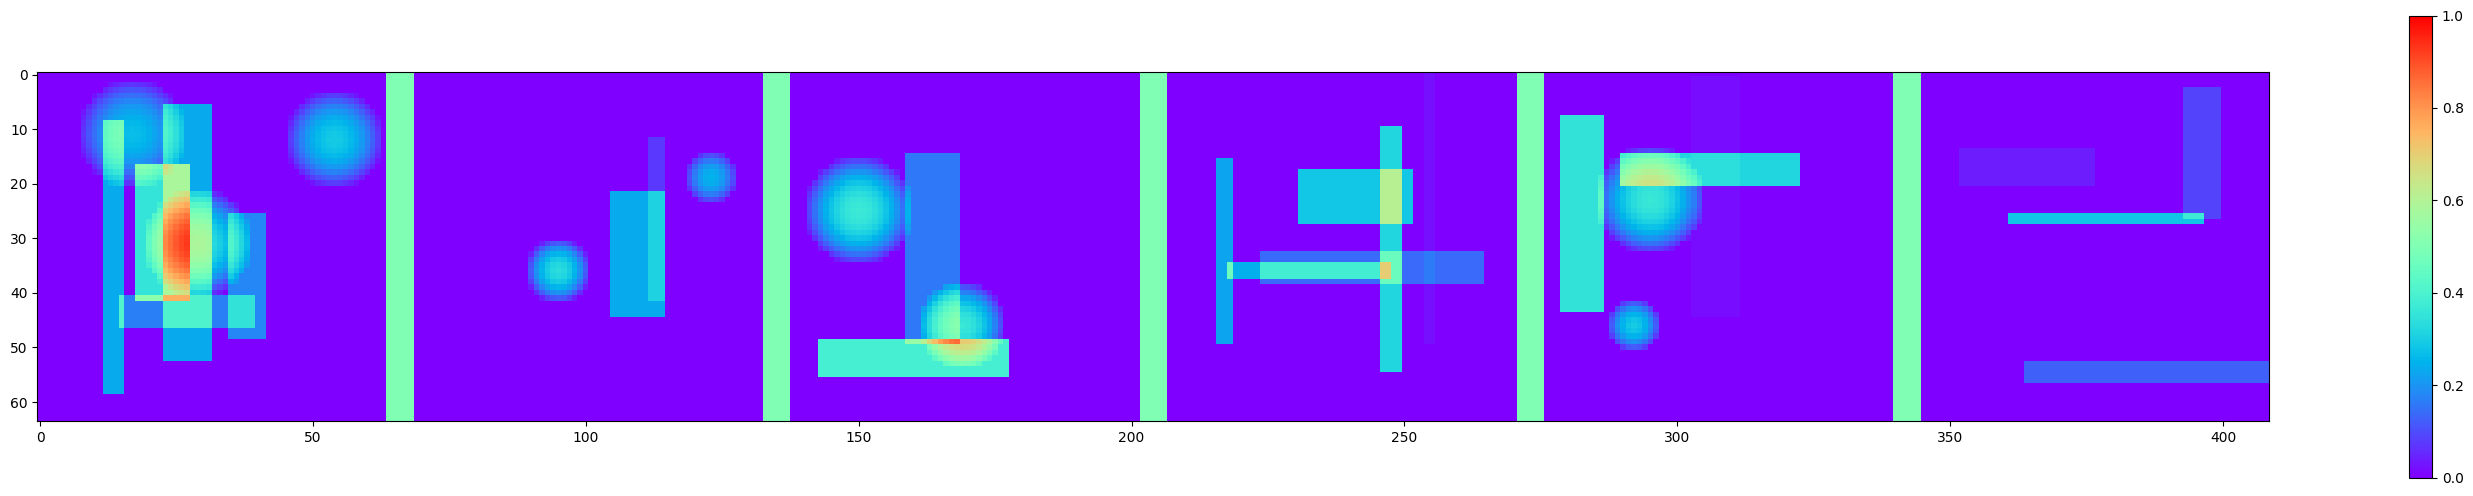

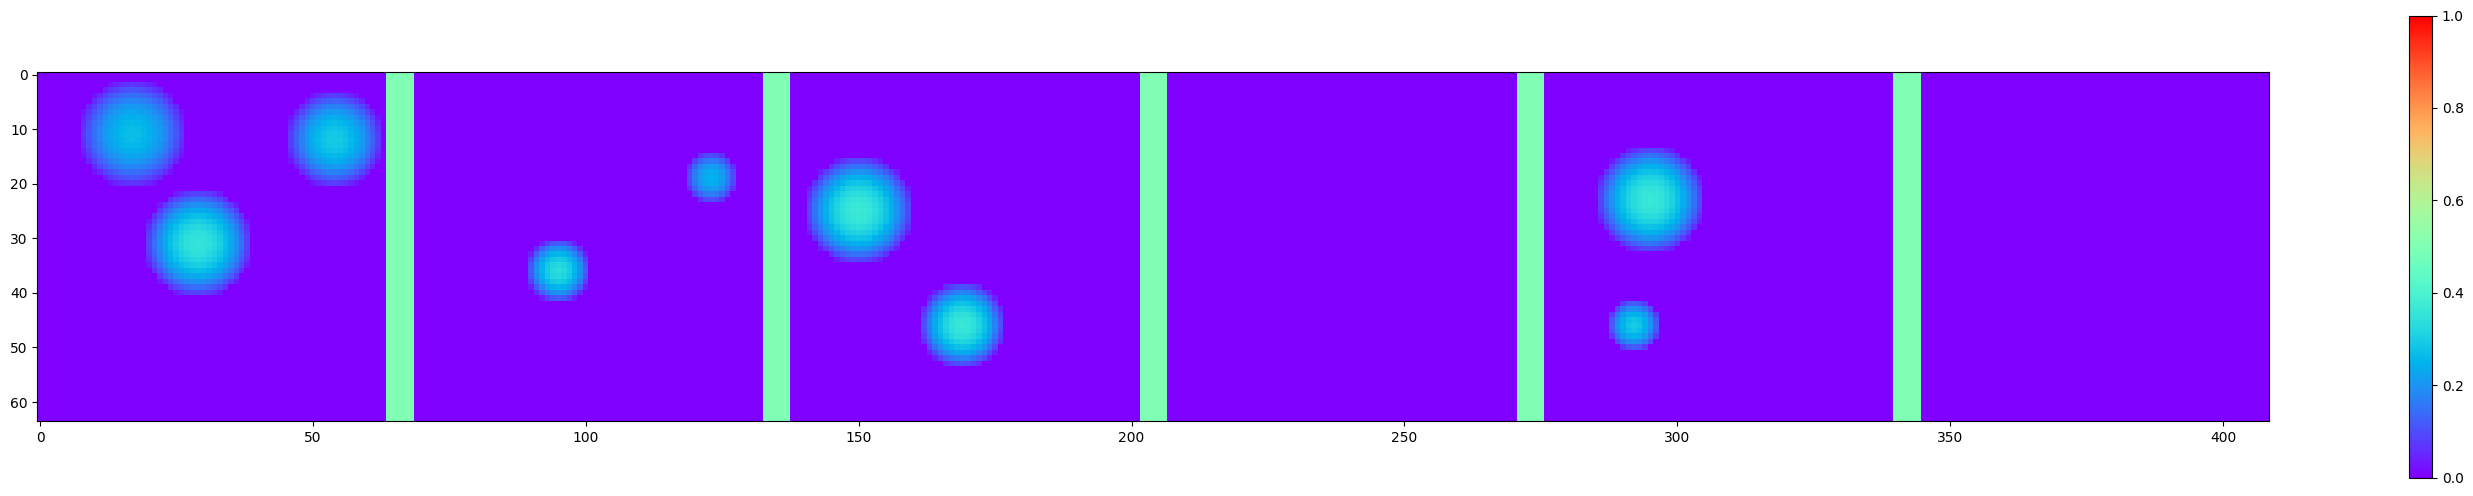

In [4]:
batch_size = 6


x, y  = gen_pointnet(batch_size)


fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(x, 6, fig1, k=0, min_scale=0, max_scale=1)


fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(y, 6, fig2, k=0, min_scale=0, max_scale=1)

# Fusion de données :


In [5]:
! pip install numba

In [6]:
from numba import jit
from numpy.random import randint


@jit(nopython=True)
def get_equation(coords_1, coords_2):
  # rustine pour éviter les pbs. lon lat étant données à 10-5 près:
  eps = 10**-5
  if coords_2[0] == coords_1[0] :
      m = (coords_2[1] - coords_1[1]) / (eps + coords_2[0] - coords_1[0])
  elif coords_2[1] == coords_1[1] :
      m = (eps + coords_2[1] - coords_1[1]) / (coords_2[0] - coords_1[0])
  else:
      m = (coords_2[1] - coords_1[1]) / (coords_2[0] - coords_1[0])
  a =  -m
  b =  1
  c =  m*coords_1[0]  - coords_1[1]
  return a,b,c



@jit(nopython=True)
def get_dists(coords_1, coords_2, matrix):

  """
  Compute intersection length between
  [coords_1, coords_2] and pixel_ij
  should have: coords_1[0] < coords_2[0]
  """
  a, b, c = get_equation(coords_1, coords_2)
  # print("equation :", a, b ,c)
  N,M = matrix.shape
  # Indx = np.arange(0,M).reshape(1,M).repeat(N,axis = 0)
  # Indy = np.arange(N-1,-1,-1).reshape(N,1).repeat(M,axis = 1)

  Indx = np.arange(0,M).repeat(N).reshape(M,N).transpose((1,0))
  Indy = np.arange(N-1,-1,-1).repeat(M).reshape(N,M)

  # print(Indx == np.arange(0,M).repeat(N).reshape(M,N).transpose((1,0)))
  # print(Indy == np.arange(N-1,-1,-1).repeat(M).reshape(N,M))
  # raise Exception('')

  inds_1 = (np.ceil(coords_1[0]), np.ceil(coords_1[1]))
  inds_2 = (np.ceil(coords_2[0]), np.ceil(coords_2[1]))

  coord_l = min(coords_1[0], coords_2[0])
  coord_r = max(coords_1[0], coords_2[0])
  coord_d = min(coords_1[1], coords_2[1])
  coord_u = max(coords_1[1], coords_2[1])

  eps = 10**-6
  ind_l = int(np.floor(coord_l))
  ind_r = int(np.floor(coord_r - eps))
  ind_d = int(np.floor(coord_d))
  ind_u = int(np.floor(coord_u - eps))


  # for each pixel i,j: the sign of Mld[i,j]
  # gives the relative position of the left/down corner
  # wrt the line ax + by + c = 0
  Mld = (a * Indx + b * Indy + c)
  Mrd = (a * (Indx + 1) + b * Indy + c)
  Mlu = (a * Indx + b * (Indy + 1) + c)
  Mru = (a * (Indx + 1) + b * (Indy + 1) + c)

  # intersections with l/r edges :
  Xl = (Indx + 0.) #.astype(float)
  Xr = (Indx + 1.) #.astype(float)
  Yl = (- a * Indx - c) / b
  Yr = (- a * (Indx + 1) - c) / b


  # intersections with u/d edges :
  Xd = (- b * Indy - c) / a
  Xu = (- b * (Indy + 1) - c) / a
  Yd = (Indy + 0.) #.astype(float)
  Yu = (Indy + 1.) #.astype(float)

  # case of pixels 1 & 2
  if a >= 0:
    Xl[N - 1 - ind_u,ind_l] = coord_l
    Xu[N - 1 - ind_u,ind_l] = coord_l

    Xr[N - 1 - ind_d,ind_r] = coord_r
    Xd[N - 1 - ind_d,ind_r] = coord_r

    Yu[N - 1 - ind_u,ind_l] = coord_u
    Yl[N - 1 - ind_u,ind_l] = coord_u

    Yd[N - 1 - ind_d,ind_r] = coord_d
    Yr[N - 1 - ind_d,ind_r] = coord_d


  else:
    Xl[N - 1 - ind_d,ind_l] = coord_l
    Xd[N - 1 - ind_d,ind_l] = coord_l

    Xr[N - 1 - ind_u,ind_r] = coord_r
    Xu[N - 1 - ind_u,ind_r] = coord_r

    Yu[N - 1 - ind_u,ind_r] = coord_u
    Yr[N - 1 - ind_u,ind_r] = coord_u

    Yd[N - 1 - ind_d,ind_l] = coord_d
    Yl[N - 1 - ind_d,ind_l] = coord_d


  # Building distance matrix
  Dists = 0. * Xl
  # lu : path between lu, ld & lu, ru
  Mask = ((Mlu * Mld < 0) * (Mlu * Mru <= 0))
  Dists += np.sqrt((Xl - Xu)**2 + (Yl - Yu)**2) * Mask

  # lr : path between lu, ld & ru, rd
  Mask = (Mlu * Mld < 0) * (Mru * Mrd < 0)
  Dists += np.sqrt((Xl - Xr)**2 + (Yl - Yr)**2) * Mask

  # ld : path between lu, ld & ld, rd
  Mask = (Mlu * Mld < 0) * (Mld * Mrd <= 0)
  Dists += np.sqrt((Xl - Xd)**2 + (Yl - Yd)**2) * Mask

  # ur : path between lu, ru & ru, rd
  Mask = (Mlu * Mru <= 0) * (Mru * Mrd < 0)
  Dists += np.sqrt((Xu - Xr)**2 + (Yu - Yr)**2) * Mask

  # ud : path between lu, ru & ld, rd
  Mask = (Mlu * Mru <= 0) * (Mld * Mrd <= 0)
  Dists += np.sqrt((Xu - Xd)**2 + (Yu - Yd)**2) * Mask

  # rd : path between ld, rd & ru, rd
  Mask = (Mld * Mrd <= 0) * (Mru * Mrd < 0)
  Dists += np.sqrt((Xr - Xd)**2 + (Yr - Yd)**2) * Mask

  # clean outside the segment :
  Mask = (Indx >= ind_l) * (Indx <= ind_r)
  Dists *= Mask

  Mask = (Indy >= ind_d) * (Indy <= ind_u)
  Dists *= Mask

  return Dists


# @jit(nopython=True)
# def db2rain(image):
#   image = image**2 - 1
#   image[image<0] = 0

#   return image


@jit(nopython=True)
def db2rain(image):
  image = 10 * image**2 - 0.5*np.random.rand(1)
  # image[image<0] = 0
  image = np.maximum(image, 0)
  return image


@jit(nopython=True)
def create_pairs(image, n_pairs = 1):
  distx = np.random.randint(0,32, (n_pairs,))
  disty = np.random.randint(-15, 16, (n_pairs,))

  perceived_image = db2rain(image)
  trace =  np.zeros(image.shape)
  pairs = []
  for i in range(n_pairs):

    coli0 = np.random.randint(0, 64 - distx[i], (1,)).item()
    rowi0 = np.random.randint(max(0, 0 - disty[i]), min(64, 64 - disty[i]), (1,)).item()
    coli1 = coli0 + distx[i]
    rowi1 = rowi0 + disty[i]
    xi0_local = np.random.rand(1).item()
    xi1_local = (distx[i] + np.random.rand(1)).item()

    xi0_global = coli0 + xi0_local
    xi1_global = coli0 + xi1_local

    if rowi1 > rowi0:
        rowi_max = rowi1
        rowi_min = rowi0
        yi0_local = rowi1 - rowi0 + np.random.rand(1).item()
        yi1_local =  np.random.rand(1).item()
        yi0_global = 64 - rowi1 + yi0_local
        yi1_global = 64 - rowi1 + yi1_local

    else :
        rowi_max = rowi0
        rowi_min = rowi1
        yi1_local = rowi0 - rowi1 + np.random.rand(1).item()
        yi0_local =  np.random.rand(1).item()
        yi0_global = 64 - rowi0 + yi0_local
        yi1_global = 64 - rowi0 + yi1_local



    cropi = perceived_image[0, rowi_min:rowi_max+1, coli0:coli1+1]
    # print((xi0_local, yi0_local), (xi1_local, yi1_local), cropi.shape)
    distsi = get_dists((xi0_local, yi0_local), (xi1_local, yi1_local), cropi)
    meani = np.sum(distsi * cropi) / np.sum(distsi)
    trace[0, rowi_min:rowi_max+1, coli0:coli1+1] += (0.2 + meani) * (distsi > 0)
    pairs.append(((xi0_global, yi0_global), (xi1_global, yi1_global), meani))

  return perceived_image, trace, pairs




def generate_image(image, lambda_pairs=0.01, lambda_rec=0.001,
                             lambda_noisy_rec=0.001, lambda_disc=0.001,
                             lambda_square=0., pola=[0,0.5,0.1]):

    clean_image = image
    for k in range(np.random.poisson(lambda_disc*64*64)):
        r = randint(5,10)
        clean_image=simu_disc(image, lambda a,x  : (0.39 - 0.36*a/x**2)*(a < x**2), radius = r)  #0.47 pour avoir 40 dB
    for k in range(np.random.poisson(lambda_square*64*64)):
        r = randint(5,10)
        image=simu_square(clean_image, lambda a,x  : (0.5 - 0.45*a/x)*(a < x) , diag = r)  #0.47 pour avoir 40 dB
#        print(r)
    for i in range(np.random.poisson(lambda_rec*64*64)):
        L=randint(20,50)
        l=randint(2,10)
        image= simu_rec(image,L,l)
    for j in range(np.random.poisson(lambda_noisy_rec*64*64)):
        L=randint(10,30)
        l=randint(10,30)
        image = simu_noisy_rec(image,L,l)
        # 0.3*np.exp(-0.1 * a/x)*(a < x**2)  #image=simu_disque(image, lambda a,x  : 1.0*(a < x**2)  )
    # on ajoute le deuxième canal où les échanges entre signaux seront
    # représentés


    return clean_image, image

def make_image_with_pairs(rec, freq_integrated_signals, noisy_rec ,disc,square, pola, n_pairs):
    image=torch.zeros([1,64, 64])
    clean_image, noisy_image = generate_image(image, lambda_pairs=freq_integrated_signals,
                                     lambda_rec=rec, lambda_noisy_rec=noisy_rec,
                                     lambda_disc=disc, lambda_square=square,
                                     pola= pola)
    ground_clean_image, trace, pairs = create_pairs(clean_image.numpy(), n_pairs)
    return noisy_image.unsqueeze(0), torch.tensor(ground_clean_image).unsqueeze(0),  torch.tensor(trace).unsqueeze(0), pairs

def make_batch_with_pairs(batch_size, freq_integrated_signals, rec, noisy_rec,
                                disc, square=0.001, pola=[0], n_pairs=1):
    ground_clean_images = []
    noisy_images = []
    traces = []
    pairs_list = []
    for i in range(batch_size):
        noisy_image, ground_clean_image, trace, pairs = make_image_with_pairs(rec, freq_integrated_signals,
                                                          noisy_rec, disc, square, pola, n_pairs)
        ground_clean_images.append(ground_clean_image)
        noisy_images.append(noisy_image)
        traces.append(trace)
        pairs_list.append(pairs)

    ground_clean_images=torch.cat(ground_clean_images, dim = 0)
    noisy_images=torch.cat(noisy_images, dim = 0)
    traces=torch.cat(traces, dim = 0)

    return ground_clean_images, noisy_images, traces, pairs_list


def extract_random_points(images, M):
    """
    Extract M random values from each image in a batch, along with their normalized coordinates, using PyTorch.

    Args:
    images (torch.Tensor): Input batch of images of shape (N, 1, S, S).
    M (int): Number of random points to extract from each image.

    Returns:
    torch.Tensor: Batch of extracted points and their values, shape (N, M, 3).
    """
    N, _, S, _ = images.shape
    # Flatten the spatial dimensions
    flat_images = images.view(N, S * S)

    # Randomly sample M indices for each image in the batch
    indices = torch.randint(0, S * S, (N, M), device=images.device)

    # Gather the values from these indices for all images
    sampled_values = torch.gather(flat_images, 1, indices)

    # Calculate coordinates from indices
    rows = indices // S
    cols = indices % S

    # Normalize coordinates to be between 0 and 1
    normalized_rows = rows.float() / S
    normalized_cols = cols.float() / S

    # Stack the normalized coordinates with the values
    result = torch.stack((normalized_rows, normalized_cols, sampled_values.float()), dim=-1)

    return result

def set_tensor_values(X, extracted_data, S):
    """
    Set values in tensor X using coordinates and values extracted from another tensor.

    Args:
    X (torch.Tensor): Target tensor where values need to be set, shape (N, 1, S, S).
    extracted_data (torch.Tensor): Data containing normalized coordinates and values, shape (N, M, 3).
    S (int): Size of the spatial dimension of X.

    Returns:
    torch.Tensor: Updated tensor X with new values set at specified coordinates.
    """
    N, M, _ = extracted_data.shape

    # Extract normalized coordinates and values
    normalized_rows = extracted_data[:, :, 0]
    normalized_cols = extracted_data[:, :, 1]
    values = extracted_data[:, :, 2]

    # Convert normalized coordinates back to original scale
    rows = (normalized_rows * S).long()
    cols = (normalized_cols * S).long()

    # Use the coordinates to set the values in X
    for i in range(N):
        for j in range(M):
            X[i, 0, rows[i, j], cols[i, j]] = values[i, j]

    return X


def pairs_list2pairs_batch(list_of_lists, size = 64.):
    """
    Transform a list of lists containing triplets into a 3D numpy array.

    Args:
    list_of_lists (list): List of Nb lists, each containing Np triplets as described.

    Returns:
    np.ndarray: A 3D numpy array of shape (Nb, Np, 5) as specified.
    """
    # Using list comprehension to transform and flatten each triplet
    batch = torch.tensor([
        [
            [p1[0]/size, p1[1]/size, p2[0]/size, p2[1]/size, val]
            for (p1, p2, val) in sublist
        ]
        for sublist in list_of_lists
    ])

    return batch

def gen_image_with_pairs(batch_size, n_pairs, n_points):
    freq_integrated_signals = 0.005
    ground_clean_images, noisy_images, traces, pairs_list = make_batch_with_pairs(batch_size, freq_integrated_signals, 0.001, 0, 0.001, square=0., pola=[0], n_pairs=n_pairs)
    pairs_list = pairs_list2pairs_batch(pairs_list, size = 64.)
    partial_target = extract_random_points(ground_clean_images, n_points)

    return ground_clean_images, partial_target, noisy_images, traces, pairs_list

In [7]:
batch_size = 6
n_pairs = 16
n_points = 16
full_target, partial_target, noisy_images, traces, pairs_list = gen_image_with_pairs(6, n_pairs, n_points)
print((traces>0).sum())
partial_target[:,:,2] += 0.2
traces = set_tensor_values(traces, partial_target, 64)
print((traces>0).sum())

tensor(2038)
tensor(2124)


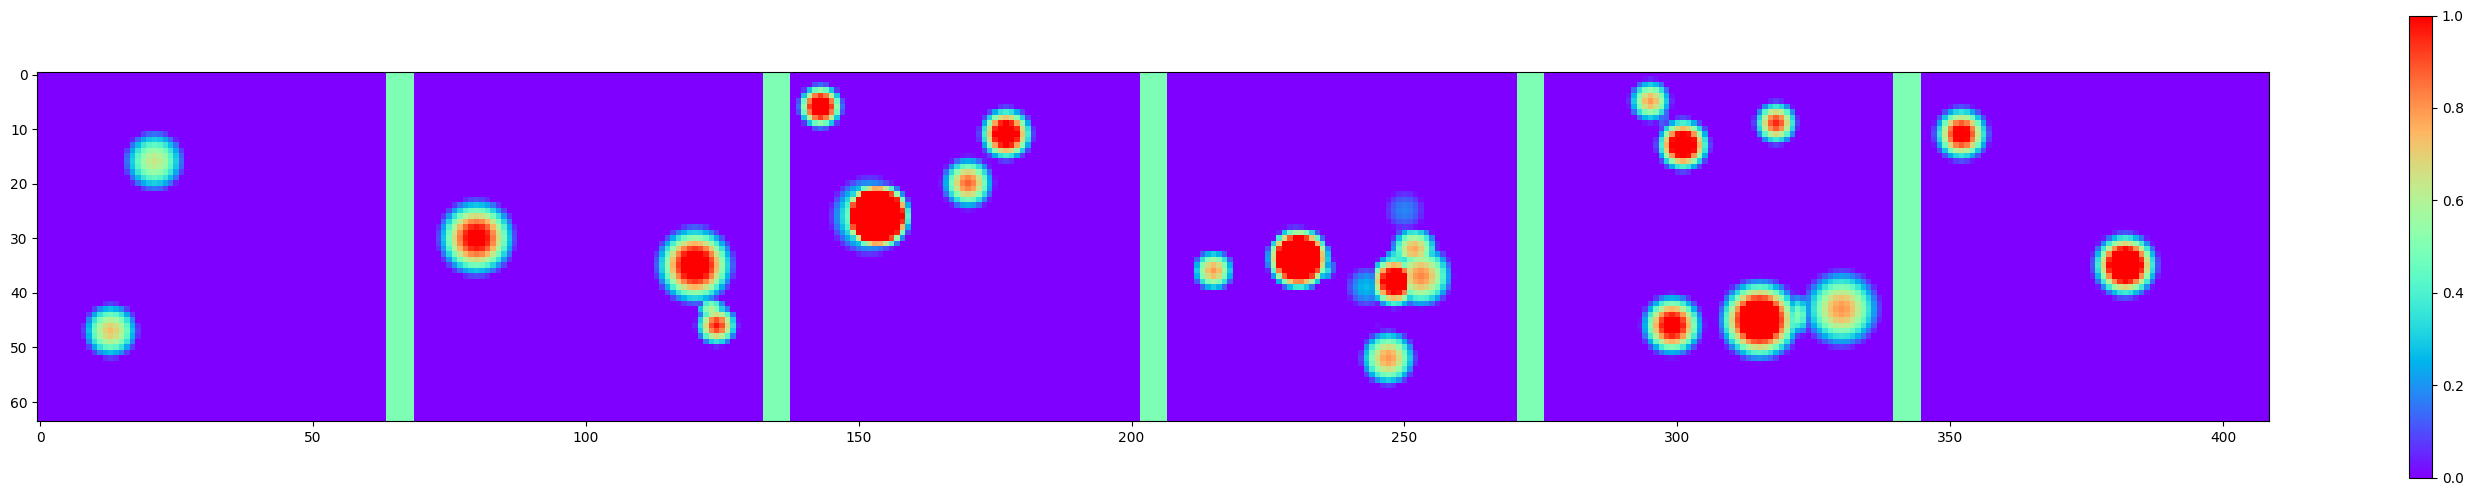

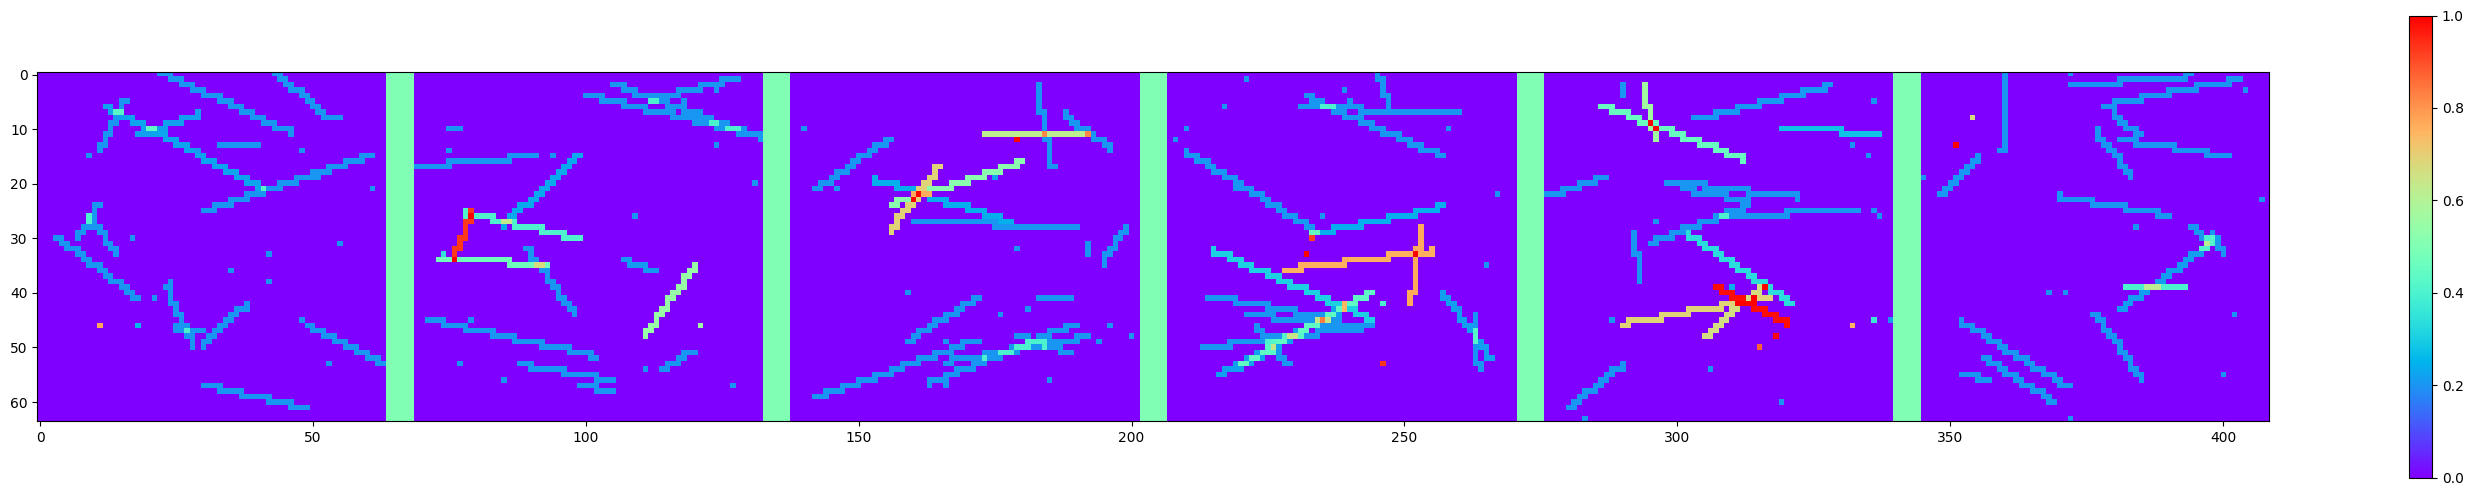

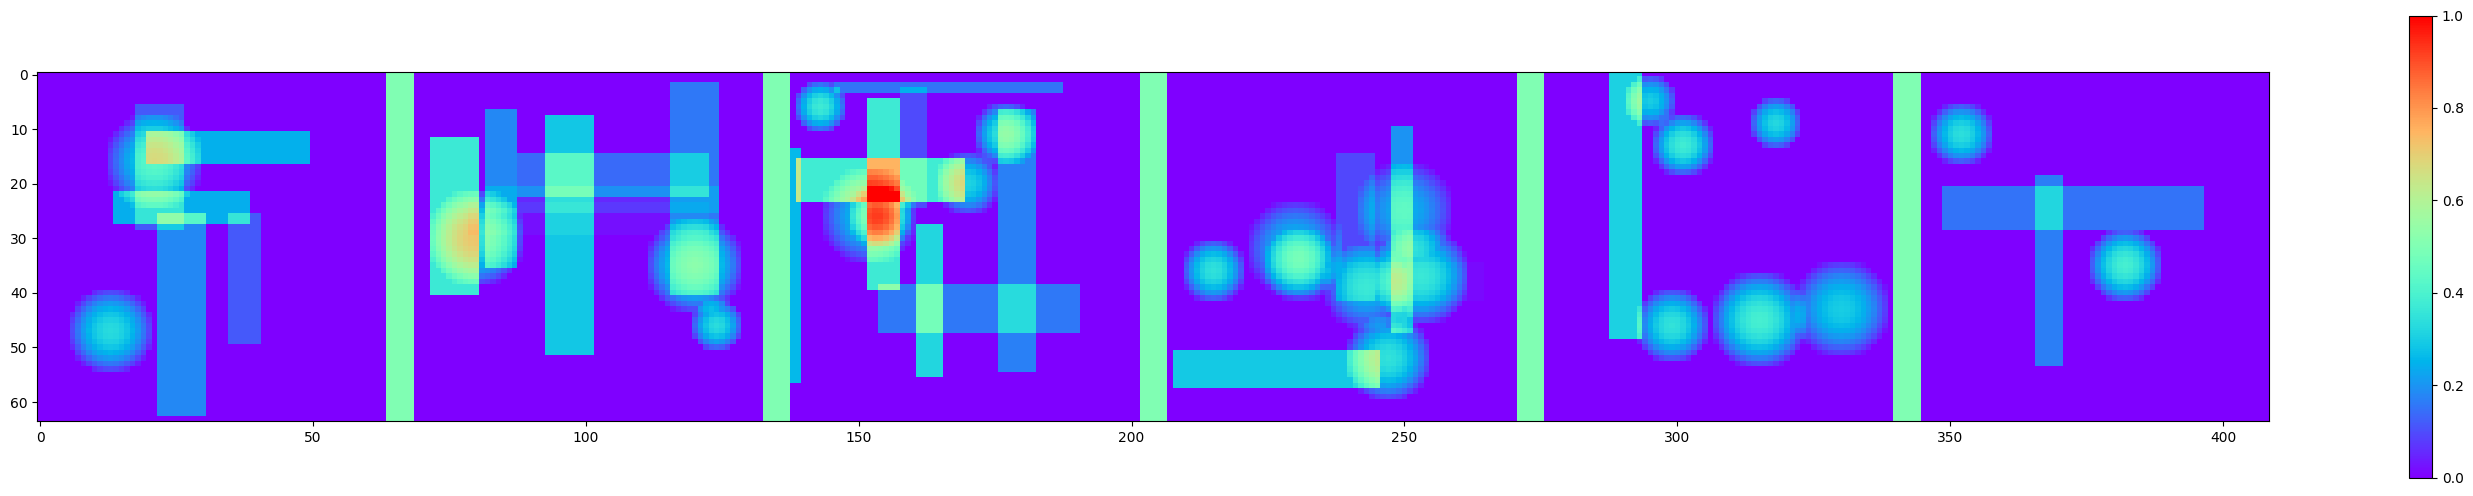

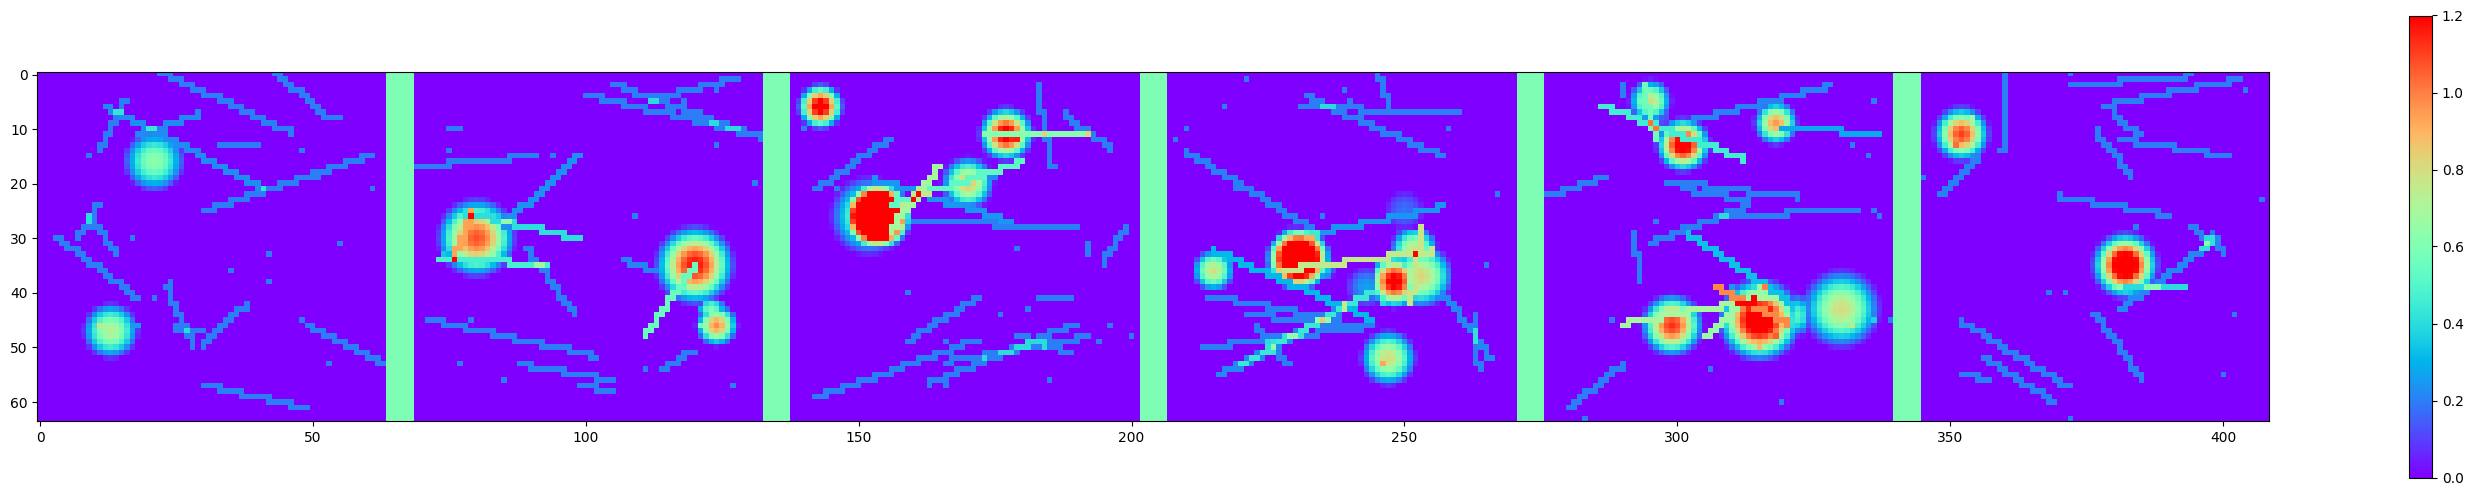

In [8]:
fig1 = plt.figure(1, figsize=(36, 6))
# champ T
voir_batch2D(full_target, 6, fig1, k=0, min_scale=0, max_scale=1)

# traces
fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(traces, 6, fig2, k=0, min_scale=0, max_scale=1)

# représentation des données d'opportunité par des segments
fig3 = plt.figure(3, figsize=(36, 6))
voir_batch2D(noisy_images, 6, fig3, k=0, min_scale=0, max_scale=1)

# représentation des données d'opportunité par des segments
fig4 = plt.figure(4, figsize=(36, 6))
full_target[traces > 0] = traces[traces > 0 ]
voir_batch2D(full_target, 6, fig4, k=0, min_scale=0., max_scale=1.2)

In [69]:
image_size = [64,64]
channels = 1
patch_size = 4
d_model = 120
mlp_expansion_ratio = 4
d_ff = mlp_expansion_ratio * d_model
n_heads = 4
n_layers = 12

In [70]:
import torch
import torch.nn as nn

class UnifiedEmbedding(nn.Module):
    def __init__(self, d_model, patch_size, channels):
        super().__init__()
        self.d_model = d_model
        self.patch_size = patch_size
        self.channels = channels
        self.dim_modality = 4
        # Positional embedding for coordinates
        self.coord_embed = nn.Linear(2, d_model // 3)

        # Modality specific embeddings
        self.patch_modality = nn.Parameter(torch.randn(self.dim_modality))
        self.point_modality = nn.Parameter(torch.randn(self.dim_modality))
        self.segment_modality = nn.Parameter(torch.randn(self.dim_modality))

        # Feature embedding for radar image patches
        self.patch_feature_embed = nn.Conv2d(channels, d_model - self.dim_modality \
                - 2 * (d_model // 3), kernel_size=patch_size, stride=patch_size)

        # Feature embedding for point and segment rain rates
        self.punctual_rain_rate_embed = nn.Linear(1, d_model - self.dim_modality \
                                                  - 2 * (d_model // 3))
        self.integrated_rain_rate_embed = nn.Linear(1, d_model - self.dim_modality \
                                                    - 2 * (d_model // 3))

    def forward(self, image, points, segments):
        B, C, H, W = image.shape
        device = image.device
        # print("Image shape:", image.shape)

        # Embedding patches
        patch_embeddings = self.patch_feature_embed(image).flatten(2).transpose(1, 2)
        # print("Patch embeddings shape:", patch_embeddings.shape)

        # Create grid for patches
        grid_x, grid_y = torch.meshgrid(torch.arange(0, H, self.patch_size), torch.arange(0, W, self.patch_size), indexing='ij')
        grid_x = grid_x.to(device)  # Move to device
        grid_y = grid_y.to(device)  # Move to device
        upleft = torch.stack((grid_x.flatten(), grid_y.flatten()), dim=-1).float()
        downright = torch.stack((grid_x.flatten() + self.patch_size, grid_y.flatten() + self.patch_size), dim=-1).float()
        # patch_pos_embeddings = self.coord_embed(upleft) + self.coord_embed(downright)
        patch_pos_embeddings = torch.cat([self.coord_embed(upleft), self.coord_embed(downright)], dim=-1)
        patch_pos_embeddings = patch_pos_embeddings.repeat(B, 1, 1)
        # print("Patch positional embeddings shape:", patch_pos_embeddings.shape)

        patch_embeddings = torch.cat([patch_embeddings, patch_pos_embeddings, self.patch_modality.unsqueeze(0).expand(B, patch_embeddings.size(1), -1)], dim=-1)
        # print("Final patch embeddings shape:", patch_embeddings.shape)

        # Embedding points
        point_pos_embeddings = self.coord_embed(points[..., :2].float())
        # print("Point positional embeddings shape:", point_pos_embeddings.shape)

        point_feature_embeddings = self.punctual_rain_rate_embed(points[..., 2:].float())
        # print("Point feature embeddings shape:", point_feature_embeddings.shape)
        point_embeddings = torch.cat([point_feature_embeddings, point_pos_embeddings, point_pos_embeddings, self.point_modality.unsqueeze(0).expand(B, points.size(1), -1)], dim=-1)
        # print("Final point embeddings shape:", point_embeddings.shape)

        # Embedding segments
        seg_pos_embeddings0 = self.coord_embed(segments[..., :2].float())
        seg_pos_embeddings1 = self.coord_embed(segments[..., 2:4].float())
        # print("segment positionnal embeddings shapes:", seg_pos_embeddings0.shape, seg_pos_embeddings1.shape)
        segment_feature_embeddings = self.integrated_rain_rate_embed(segments[..., 4:].float())
        # print("segment feature embeddings shapes:", segment_feature_embeddings.shape)
        segment_embeddings = torch.cat([segment_feature_embeddings, seg_pos_embeddings0, seg_pos_embeddings1, self.segment_modality.unsqueeze(0).expand(B, segments.size(1), -1)], dim=-1)
        # print("Final segment embeddings shape:", segment_embeddings.shape)

        # Concatenate all embeddings
        embeddings = torch.cat([patch_embeddings, point_embeddings, segment_embeddings], dim=1)
        # without points and segments :
        # embeddings = patch_embeddings
        # print("Concatenated embeddings shape:", embeddings.shape)

        return embeddings




In [54]:
# Example dimensions and instantiation
ue = UnifiedEmbedding(d_model, patch_size, channels)

In [55]:
full_target, y, x, traces, z = gen_image_with_pairs(6, n_pairs, n_points)
embeddings = ue(x, y, z)
print(embeddings.shape)

torch.Size([6, 288, 120])


In [56]:
y.shape

torch.Size([6, 16, 3])

In [71]:
class Attention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()

        # Nombre de "têtes"
        self.heads = n_heads

        # Taille des vecteurs requête, clefs, valeur
        self.head_dim = d_model // n_heads

        # Scalaire utilisé à l'étape de normalisation
        self.scale = self.head_dim ** -0.5

        # Première application linéaire
        self.qkv = nn.Linear(d_model, n_heads * self.head_dim * 3)

        # Seconde application linéaire
        self.proj = nn.Linear(n_heads * self.head_dim, d_model)


    def forward(self, x, mask=None):
        B, N, C = x.shape

        # Calcul des requêtes, clefs, valeurs
        qkv = (
            self.qkv(x)
            .reshape(B, N, 3, self.heads, self.head_dim)
            .permute(2, 0, 3, 1, 4)
        )
        q, k, v = (
            qkv[0],
            qkv[1],
            qkv[2],
        )
        # Produits scalaires
        p = (q @ k.transpose(-2, -1))

        # A décommenter pour la question 10:
        # print(q.shape, k.transpose(-2, -1).shape)

        # Etape de normalisation
        p *= self.scale
        p = p.softmax(dim=-1)

        # Somme pondérée
        x = (p @ v).transpose(1, 2).reshape(B, N, C)

        # Sortie
        x = self.proj(x)

        return x

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, out_dim=None):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.act = nn.GELU()
        if out_dim is None:
            out_dim = d_model
        self.fc2 = nn.Linear(d_ff, out_dim)

    def unwrapped(self):
        return self

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

# ou avec dropout
import torch.nn.init as init
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, out_dim=None, dropout_rate=0.1):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        init.normal_(self.fc1.weight, std=0.02)  # Example initialization
        self.act = nn.GELU()
        self.dropout = nn.Dropout(dropout_rate)
        if out_dim is None:
            out_dim = d_model
        self.fc2 = nn.Linear(d_ff, out_dim)
        init.normal_(self.fc2.weight, std=0.02)  # Example initialization

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)  # Apply dropout after activation
        x = self.fc2(x)
        return x

class Block(nn.Module):
    def __init__(self, d_model, n_heads, d_ff):
        super().__init__()
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.attn = Attention(d_model, n_heads)
        self.mlp = FeedForward(d_model, d_ff)


    def forward(self, x, mask=None, return_attention=False):
        #a modifier (voir question 14)
        y = self.attn(self.norm1(x), mask)
        y = self.mlp(self.norm2(y))
        return y


class Block(nn.Module):
    def __init__(self, d_model, n_heads, d_ff):
        super().__init__()
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.attn = Attention(d_model, n_heads)
        self.mlp = FeedForward(d_model, d_ff)

    def forward(self, x, mask=None, return_attention=False):
        x_attn = self.norm1(x)
        if return_attention:
            y, attn_weights = self.attn(x_attn, mask, return_attention=True)
        else:
            y = self.attn(x_attn, mask)
        # Applying skip connection around the attention layer
        y = x + y

        x_mlp = self.norm2(y)
        y = self.mlp(x_mlp)
        # Applying skip connection around the MLP layer
        y = y + x_mlp

        if return_attention:
            return y, attn_weights
        return y

In [14]:
! pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.1 MB/s eta 0:00:00


In [72]:
from einops import rearrange



def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.LayerNorm):
        nn.init.constant_(m.bias, 0)
        nn.init.constant_(m.weight, 1.0)

def trunc_normal_(tensor, mean=0, std=1):
    nn.init.trunc_normal_(tensor, mean=mean, std=std)


class Up0(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(Up0, self).__init__()  # Corrected super call
        self.up = nn.ConvTranspose2d(in_ch, in_ch, kernel_size=2, stride=2)
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.up(x)
        x = self.conv(x)
        return x

class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class Decoder(nn.Module):
    """
    vaut uniquement si channels = 1 et image_size =64
    """
    def __init__(self, patch_size, d_model):
        super().__init__()

        self.d_model = d_model
        self.ps = patch_size
        self.up =  Up0(d_model, 16)
        self.up2 =  Up0(16, 8)
        # self.up3 =  Up0(8, 4)
        self.outc = outconv(8, 1)

    def forward(self, x):

        x = rearrange(x, "b (h w) c -> b c h w", h=64 // self.ps)
        x = self.up(x)
        x = self.up2(x)
        # x = self.up2(x)
        # x = self.up3(x)
        x = self.outc(x)
        return x


# class Decoder(nn.Module):
#     """
#     vaut uniquement si channels = 1 et image_size =64
#     """
#     def __init__(self, patch_size, d_model):
#         super().__init__()

#         self.d_model = d_model
#         self.ps = patch_size
#         self.up =  Up0(d_model, 8)
#         # self.up2 =  Up0(16, 8)
#         # self.up3 =  Up0(8, 4)
#         self.outc = outconv(8, 1)

#     def forward(self, x):
#         x = rearrange(x, "b (h w) c -> b c h w", h=64 // self.ps)
#         x = self.up(x)
#         # x = self.up2(x)
#         # x = self.up2(x)
#         # x = self.up3(x)
#         x = self.outc(x)
#         return x

class FusionTransformer(nn.Module):
    def __init__(
        self,
        image_size,
        patch_size,
        n_layers,
        d_model,
        d_ff,
        n_heads,
        channels=1,
    ):
        super().__init__()
        self.ue = UnifiedEmbedding(d_model, patch_size, channels)
        self.patch_size = patch_size
        self.n_layers = n_layers
        self.d_model = d_model
        self.d_ff = d_ff
        self.n_heads = n_heads


        self.blocks = nn.ModuleList(
            [Block(d_model, n_heads, d_ff) for _ in range(n_layers)]
        )
        self.norm = nn.LayerNorm(d_model)

        self.apply(init_weights)

        self.decoder = Decoder(patch_size, d_model)

    def forward(self, x, y, z):
        # Embed signal
        x = self.ue(x, y, z)  # (B, N, D)

        # Process through each transformer block
        for block in self.blocks:
            x = block(x)

        # Apply final normalization
        x = self.norm(x)
        x = x[:,:256,:]

        x = self.decoder(x)

        return x


In [80]:
model = FusionTransformer(image_size, patch_size, n_layers, d_model, d_ff, n_heads, channels=1)
full_target, y, x, traces, z = gen_image_with_pairs(6, n_pairs, n_points)
model(x,y,z).shape

torch.Size([6, 1, 64, 64])

In [81]:
device = torch.device('cuda:0')
model = model.to(device)

In [75]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Assuming you have an instance of your model

total_params = count_parameters(model)

print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 2173673


In [84]:
def criterion(output, target):
    return torch.mean((output - target)**2)

def criterion(output, target):
    return torch.abs((output - target)).mean()

import torch.optim as optim
optimizer = optim.Adam(model.parameters(), 10**(-4))

In [ ]:
nepochs = 300
nbatches = 100
batchsize = 32

train_losses = []  # List to store training losses

for epoch in range(nepochs):
    print(f"Epoch {epoch + 1}/{nepochs}")

    epoch_losses = []  # List to store losses for each batch in the epoch

    for i in range(nbatches):
        # Load inputs
        full_target, partial_target, noisy_images, _, pairs_list = gen_image_with_pairs(batchsize, n_pairs, n_points)

        noisy_images = noisy_images.to(device)
        pairs_list = pairs_list.to(device)
        partial_target = partial_target.to(device)
        full_target = full_target.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(noisy_images, partial_target, pairs_list)  # Forward pass
        loss = criterion(outputs, full_target)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights

        epoch_losses.append(loss.detach().cpu().item())  # Append the loss

    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)

    print(f'Epoch loss: {epoch_loss:.4f}')


model.eval()

full_target, partial_target, noisy_images, traces, pairs_list = gen_image_with_pairs(6, n_pairs, n_points)

noisy_images = noisy_images.to(device)
pairs_list = pairs_list.to(device)
partial_target = partial_target.to(device)
partial_target[:,:,2] += 0.2
traces = set_tensor_values(traces, partial_target, 64)
full_target = full_target.to(device)

optimizer.zero_grad()  # Zero the gradients
outputs = model(noisy_images, partial_target, pairs_list)  # Forward pass


fig = plt.figure(0, figsize=(36, 6))  # first row: inputs
voir_batch2D(noisy_images.detach().cpu(), 6, fig, k=0, min_scale=0, max_scale=1)
fig = plt.figure(0, figsize=(36, 6))  # second row: outputs
voir_batch2D(outputs.detach().cpu(), 6, fig, k=0, min_scale=0, max_scale=1)
fig2 = plt.figure(1, figsize=(36, 6))  # second row: ground truth
full_target = full_target.detach().cpu()
full_target[traces > 0] = traces[traces > 0 ]
voir_batch2D(full_target.detach().cpu(), 6, fig2, k=0, min_scale=0, max_scale=1)

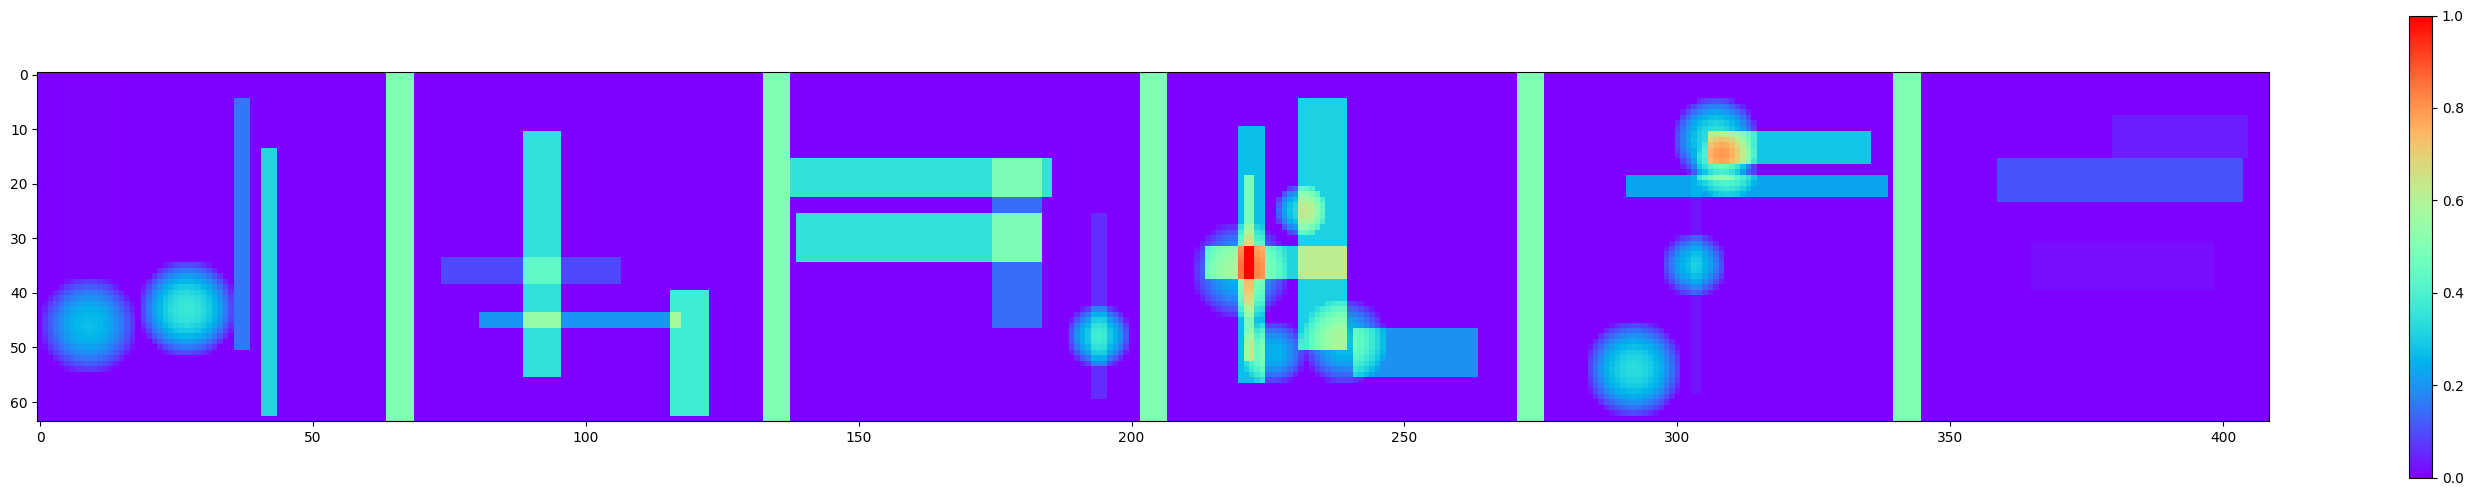

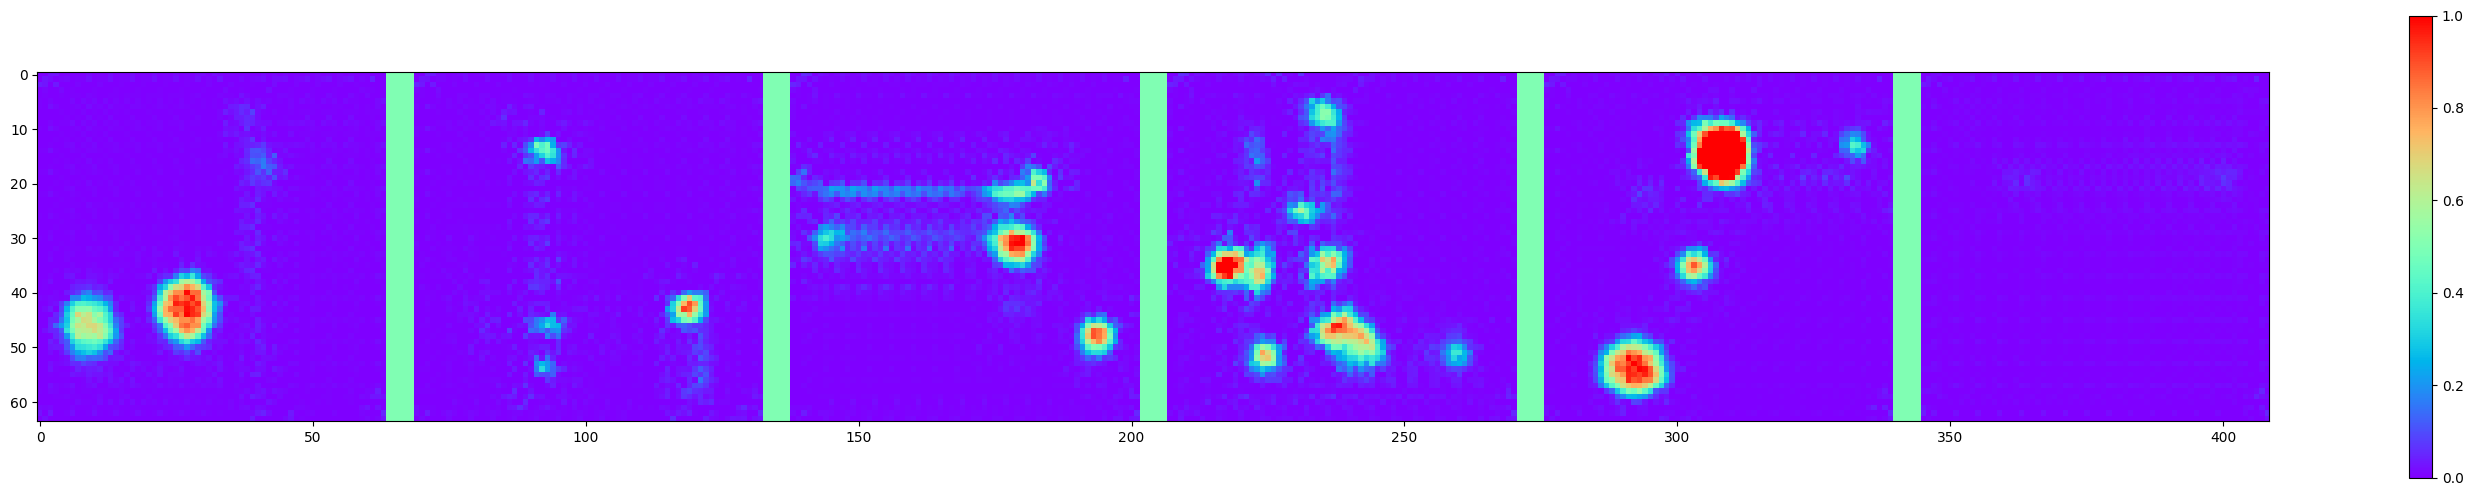

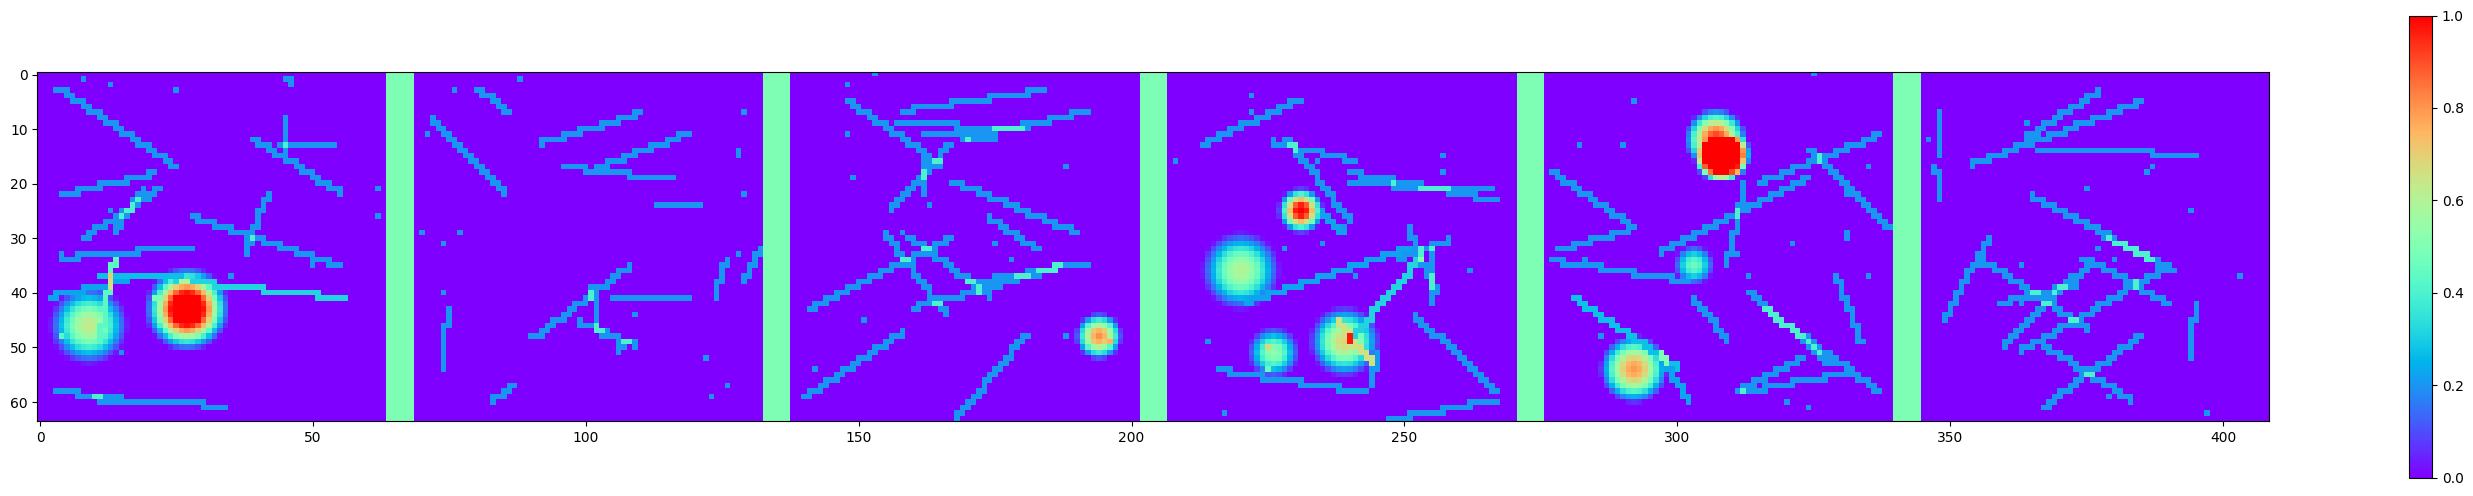

In [99]:
#visualization:

model.eval()

full_target, partial_target, noisy_images, traces, pairs_list = gen_image_with_pairs(6, n_pairs, n_points)

noisy_images = noisy_images.to(device)
pairs_list = pairs_list.to(device)
partial_target = partial_target.to(device)
partial_target[:,:,2] += 0.2
traces = set_tensor_values(traces, partial_target, 64)
full_target = full_target.to(device)

optimizer.zero_grad()  # Zero the gradients
outputs = model(noisy_images, partial_target, pairs_list)  # Forward pass


fig = plt.figure(0, figsize=(36, 6))  # first row: inputs
voir_batch2D(noisy_images.detach().cpu(), 6, fig, k=0, min_scale=0, max_scale=1)
fig = plt.figure(0, figsize=(36, 6))  # second row: outputs
voir_batch2D(outputs.detach().cpu(), 6, fig, k=0, min_scale=0, max_scale=1)
fig2 = plt.figure(1, figsize=(36, 6))  # second row: ground truth
full_target = full_target.detach().cpu()
full_target[traces > 0] = traces[traces > 0 ]
voir_batch2D(full_target.detach().cpu(), 6, fig2, k=0, min_scale=0, max_scale=1)
